### Viability for triage?

The shared task call for participation posed the question: Is NLP mature enough to be applied to clinical psychology?

The shared task, eapecially task b, is a bold approach to this question. We can imagine less ambitious ways of approaching the question than predicting an observed variable 41 years into the future with a short essay. For instance, using a writing sample at any age to assess distress and offer assistance at that same age seems useful enough, especially if the assessment could be made using incidental data like school, social or professional writing. 

However, while extreme, the precise formulation of the shared task, especially task b, is also compelling. Imagine being able to reduce mental and other related health issues in later life, e.g., diabetes, through early intervention. To provide some analysis and discussion, we reframe the original question in these terms. Specifically, we ask: Might it be possible to re-allocate resources based on predicted distress in a way that improves outcomes at age 52?

Notes on using text to predict distress at ages 42 and 50:
* ROC curves for SGDR-all at 42 and 50 (same predictions) have a single inflection point
* This suggests that there are few predicted values, confirmed by review of predictions
* This may be because few combinations of non-zero features are present in the test data
* Our model wasn't able to utilise text to predict distress at ages 42 and 50

Notes on using text to predict distress at ages 23 and 33:
* ROC curves suggest more success predicting distress at lower ages
* This is perhaps not surprising since it involves less intervening time
* We expect accumulation of life events to become a stronger factor over time
* For age 23, SGDR-all is better than baseline at higher TP/FP rates
* For age 33, aseline is better at low TP/FP rates, while SGDR-all is better at higher TP/FP rates

Selecting an operating point:
* Imagine we have a budget to assess/reat approximately 30% of individuals
* At a threshold of 1.456, the model with text features has a TP rate of 0.617 and a FP rate of 0.282
* I.e., in order to identify 61.7% of sufferers, we'd need to assess/treat 28.2% of non-sufferers
* Note non-sufferers outnumber sufferers approximately 12:1 in our data
* At a similar threshold of 1.672, the baseline model achieves a slightly lower TP rate of 60% with a similar FP rate of 28.4%
* We could select these as our operating points
* TODO calculate significance at operating point — are baseline and text models different???

A worked example:
* Imagine we have a clinic working with a group of 1 million individuals
* The clinic can't assess this entire population, let alone treat them
* Let's assume that the incidence of depression (distress >= 4) at age 23 is 7.5%
* Let's assume that intervention at age 11 can reduce distress at age 23 in all cases
* Let's assume that the clinic can intervene with 300,000 individuals
* Let's assume that we have access to text, gender and socio-economic data at age 11
* If we have no intervention, we expect 75,000 individuals to suffer depression at age 23
* If we randomly sample individuals for intervention, we expect 22,500 successful treatments leaving 52,500 sufferers
* If we sample with the baseline model, we expect 45,000 successful treatments leaving 30,000 sufferers
* If we sample with the text model, we expect 46,275 successful treatments leaving 28,725 sufferers

Discussion on generational change, language change and model updating:
* need to maintain separate models for subjects born in different years
* or, need to re-calibrate regularly as language and norms change over time
* or, need to select features that generalise across time

In [1]:
from data import load_jsonl
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.utils import resample
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def knit(out, model, thresh, pred_thresh=None):
    y_test, y_pred = [], []
    # read predictions
    with open(f'{model}-{out}-test-no-round.csv') as fh:
        preds = {d['Id']: float(d['Pred']) for d in csv.DictReader(fh)}
    # read gold
    with open(f'../data/clpsych_2018_test_data/{out}_KEY.csv') as fh:
        for d in csv.DictReader(fh):
            y_test.append(float(d[out]) >= thresh)
            if pred_thresh is None:
                y_pred.append(preds[d['clp18_id']])
            else:
                y_pred.append(preds[d['clp18_id']] >= pred_thresh)
    return y_test, y_pred

def make_roc_plot(a, thresh=4.0):
    out = f'a{a}_pdistress'
    # calculate baseline scores
    y_bln_test, y_bln_pred = knit(out, 'baseline', thresh)
    fpr_bln, tpr_bln, _ = roc_curve(y_bln_test, y_bln_pred)
    auc_bln = roc_auc_score(y_bln_test, y_bln_pred)
    # calculate kitchen sink scores 
    y_all_test, y_all_pred = knit(out, 'SGDR-all', thresh)
    fpr_all, tpr_all, _ = roc_curve(y_all_test, y_all_pred)
    auc_all = roc_auc_score(y_all_test, y_all_pred)
    # make plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_bln, tpr_bln, label=f'ModelA (AUC: {auc_bln:.3})')
    plt.plot(fpr_all, tpr_all, label=f'ModelB (AUC: {auc_all:.3})')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve — {out}>={thresh} — N={len(y_bln_test)}')
    plt.legend(loc='best')

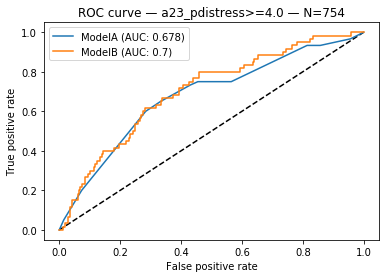

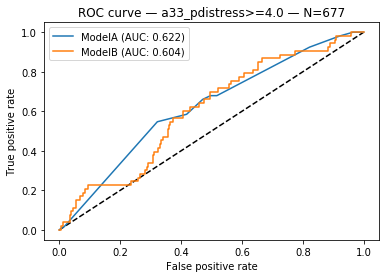

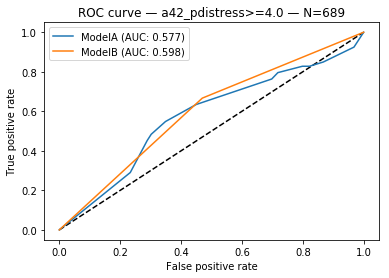

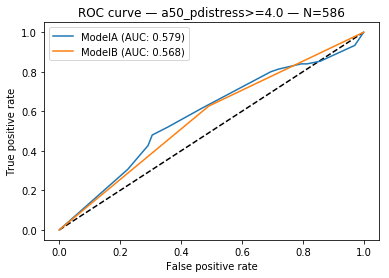

In [3]:
plt.figure(1)
make_roc_plot(23)
plt.show()
plt.figure(2)
make_roc_plot(33)
plt.show()
plt.figure(3)
make_roc_plot(42)
plt.show()
plt.figure(4)
make_roc_plot(50)
plt.show()

In [4]:
!for f in *-no-round.csv; do echo $f; echo; cut -d, -f2 $f | sort | uniq -c; echo; echo; done

SGDR-all-a23_pdistress-test-no-round.csv

















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































SGDR-all-a42_pdistress-test-no-round.csv






SGDR-all-a50_pdistress-test-no-round.csv






baseline-a23_pdistress-test-no-round.csv



  37 0.544068695486007
  93 0.7173744835343924
  42 0.8876922861769936
 252 0.9241699787697424
  82 0.960330546128982
  23 1.2535061530658287
  22 1.2919219036882001
  88 1.4652276917365854
  46 1.6355454943791867
 232 1.6720231869719355
  64 1.708183754331175
  19 2.0013593612680216
   1 Pred


baseline-a33_pdistress-test-no-round.csv

  37 0.6201737886642014
  42 0.640897234058228
  93 0.7036269724178772
 334 0.7819932088418691
  23 0.9996341463890343
  22 1.1314285405733908
  46 1.1521519859674174
  88 1.2148817243270666
 296 1.2932479607510583
  19 1.5108888982982236
   1 Pred


baseline-a42_pdistress-test-no-round.csv

  37 0.8216764451994374
  93 0.9861280157541095
  42 1.0416961052347462
  23 1.1819522902693849
  82 1.3246259823110134
  22 1.3251710595194202
 252 1.3269081625484218
  88 1.4896226300740922
  46 1.5451907195547288
  19 1.6854469045893674
  64 1.8281205966309961
 232 1.8304027768684044
   1 Pred


baseline-a50_pdistress-test-no-round.csv

  37 0.8216764451994374
  

### Predicting distress at ages 23 and 33

In [5]:
def print_thresholds(out, model, thresh):
    print(f'{model} thresholds ({out} >= {thresh})\n')
    y_test, y_pred = knit(out, model, thresh)
    print('  fpr      tpr      prp      thr')
    for fpr, tpr, thr in zip(*roc_curve(y_test, y_pred)):
        print(f'{fpr:5.3f}    {tpr:5.3f}    {len([p for p in y_pred if p>=thr])/len(y_pred):5.3f}    {thr:5.3f}')

In [6]:
print_thresholds('a23_pdistress', 'baseline', 4.0)

baseline thresholds (a23_pdistress >= 4.0)

  fpr      tpr      prp      thr
0.000    0.000    0.000    3.001
0.014    0.050    0.017    2.001
0.073    0.200    0.084    1.708
0.284    0.600    0.309    1.672
0.333    0.650    0.358    1.636
0.431    0.733    0.455    1.465
0.455    0.750    0.479    1.292
0.476    0.750    0.497    1.254
0.565    0.750    0.580    0.960
0.814    0.933    0.824    0.924
0.857    0.933    0.863    0.888
0.957    0.967    0.958    0.717
1.000    1.000    1.000    0.544


In [7]:
print_thresholds('a23_pdistress', 'SGDR-all', 4.0)

SGDR-all thresholds (a23_pdistress >= 4.0)

  fpr      tpr      prp      thr
0.000    0.000    0.000    3.540
0.001    0.000    0.001    2.540
0.012    0.000    0.011    2.109
0.012    0.017    0.012    2.103
0.019    0.017    0.019    2.025
0.019    0.033    0.020    2.011
0.029    0.033    0.029    1.973
0.029    0.067    0.032    1.945
0.035    0.067    0.037    1.935
0.035    0.100    0.040    1.922
0.036    0.100    0.041    1.922
0.036    0.117    0.042    1.916
0.040    0.117    0.046    1.896
0.040    0.150    0.049    1.887
0.061    0.150    0.068    1.825
0.061    0.183    0.070    1.812
0.065    0.183    0.074    1.808
0.065    0.200    0.076    1.806
0.069    0.200    0.080    1.791
0.069    0.217    0.081    1.791
0.075    0.217    0.086    1.776
0.075    0.233    0.088    1.770
0.084    0.233    0.095    1.760
0.084    0.267    0.098    1.759
0.094    0.267    0.107    1.746
0.094    0.283    0.109    1.746
0.099    0.283    0.114    1.740
0.099    0.300    0.115    1.739

### Confidence intervals at selected operating points

In [8]:
y_test, y_pred = knit('a23_pdistress', 'baseline', 4.0, pred_thresh=1.672)
print(recall_score(y_test, y_pred, pos_label=True))
print(1 - recall_score(y_test, y_pred, pos_label=False))

0.6
0.2838616714697406


In [9]:
def ci(values, alpha=0.95):
    v = sorted(values)
    lower = np.percentile(v, (1-alpha)/2)
    upper = np.percentile(v, alpha+((1-alpha)/2))
    return lower, upper

def bootstrap_ci(out, model, thresh, pred_thresh, n_bootstraps=100):
    y_test, y_pred = knit(out, model, thresh, pred_thresh=pred_thresh)
    # calculate sensitivity and false positive rate n_bootstraps times
    tpr, fpr = [], []
    for i in range(n_bootstraps):
        b_test, b_pred = resample(y_test, y_pred)
        tpr.append(recall_score(b_test, b_pred, pos_label=True))
        fpr.append(1 - recall_score(b_test, b_pred, pos_label=False))
    # calculate confidence intervals
    print(f'{model} CIs — {out}>={thresh} — pred>={pred_thresh}')
    print('TPR: [{:5.3f}..{:5.3f}]'.format(*ci(tpr)))
    print('FPR: [{:5.3f}..{:5.3f}]'.format(*ci(fpr)))

In [10]:
bootstrap_ci('a23_pdistress', 'baseline', 4.0, 1.672)  # wha?

baseline CIs — a23_pdistress>=4.0 — pred>=1.672
TPR: [0.455..0.489]
FPR: [0.250..0.250]


In [11]:
bootstrap_ci('a23_pdistress', 'SGDR-all', 4.0, 1.456)  # wha?

SGDR-all CIs — a23_pdistress>=4.0 — pred>=1.456
TPR: [0.446..0.454]
FPR: [0.248..0.252]


### Lower thresholds are not more discriminative for predicting at 23

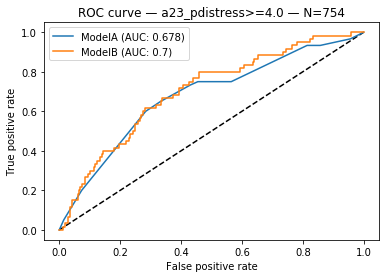

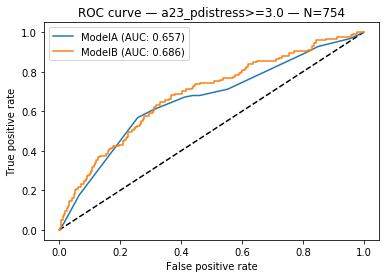

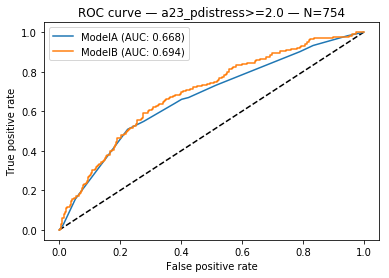

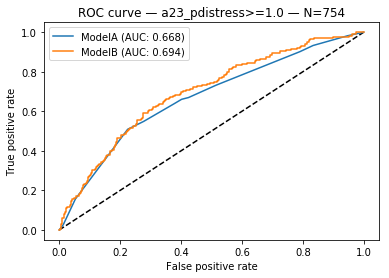

In [12]:
plt.figure(1)
make_roc_plot(23, thresh=4.0)
plt.show()
plt.figure(2)
make_roc_plot(23, thresh=3.0)
plt.show()
plt.figure(3)
make_roc_plot(23, thresh=2.0)
plt.show()
plt.figure(4)
make_roc_plot(23, thresh=1.0)
plt.show()